In [150]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 



In [151]:
df_y = pd.read_csv('project_train_y.csv')
df_X = pd.read_csv('project_train_x.csv')


In [160]:
# Define the model
class Classifier(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)


  
  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out



#class Net(nn.Module):
    #def __init__(self):
    #    super(Net, self).__init__()
   #     self.fc1 = nn.Linear(in_features=784, out_features=128)
  #      self.fc2 = nn.Linear(in_features=128, out_features=64)
 #       self.fc3 = nn.Linear(in_features=64, out_features=7)
#
    #     x = torch.relu(self.fc1(x))
  #      x = torch.relu(self.fc2(x))
 #       x = self.fc3(x)
#        return x  



# Initialize the model
input_size = 12 # Size of input data (10 features in the dataset)
hidden_size = 13 # Size of hidden layer
hidden_size1 = 200
num_classes = 7 # Number of classes (drug consumption or not)
model = Classifier(input_size, hidden_size, num_classes)

# Load the  data

def read_dataset(feature_file,label_file):
    df_X = pd.read_csv(feature_file)
    df_y = pd.read_csv(label_file)
    df_y.loc[df_y['Y1'] <= 3, 'Y1'] = 0
    df_y.loc[df_y['Y1'] > 3, 'Y1'] = 1
    X = df_X.values #convert values in dataframe to numpy 2-D array
    y = df_y.values.reshape(-1)   #convert values in dataframe to numpy 1-D array
    return X,y

def normalize_features(X_train_norm, X_test_norm):
    from sklearn.preprocessing import StandardScaler #import libaray
    scaler = StandardScaler() # call an object function
    scaler.fit(X_train) # calculate mean, std in X_train
    X_train_norm = scaler.transform(X_train) # apply normalization on X_train
    X_test_norm = scaler.transform(X_test) # we use the same normalization on X_test
    return X_train_norm, X_test_norm


X_train, y_train = read_dataset('fairness_x_train.csv', 'fairness_y_train.csv')
X_test, y_test = read_dataset('project_test_x.csv', 'project_test_y.csv')
X_train, X_test = normalize_features(X_train, X_test)


train_data = torch.from_numpy(X_train).float()
test_data = torch.from_numpy(X_test).float()

trainset = torch.utils.data.TensorDataset(train_data, torch.from_numpy(y_train.ravel()))
testset = torch.utils.data.TensorDataset(test_data, torch.from_numpy(y_test.ravel()))

kwargs = {'num_workers': 2, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, shuffle=False, **kwargs)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
  for inputs, labels in train_loader:
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  if (epoch+1) % 2 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
 
# Test the model
with torch.no_grad():
  correct = 0
  total = 0
  for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f'Accuracy of the model on the test data: {100 * correct / total} %')


Epoch [2/20], Loss: 0.4379
Epoch [4/20], Loss: 0.4951
Epoch [6/20], Loss: 0.5272
Epoch [8/20], Loss: 0.5121
Epoch [10/20], Loss: 0.4479
Epoch [12/20], Loss: 0.2936
Epoch [14/20], Loss: 0.4371
Epoch [16/20], Loss: 0.3779
Epoch [18/20], Loss: 0.7397
Epoch [20/20], Loss: 0.6272
Accuracy of the model on the test data: 78.73015873015873 %


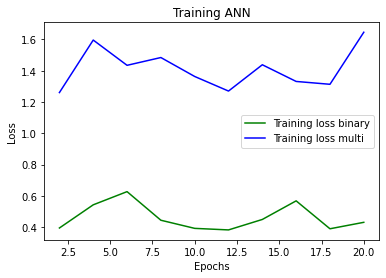

In [153]:
epoch = [2,4,6,8,10,12,14,16,18,20]
loss_train_b = [0.3953,0.5433,0.6275,0.4448,0.3929,0.3830,0.4498,0.5686,0.3903,0.4315]
loss_train_m = [1.2602,1.5955,1.4342,1.4839,1.3629,1.2698,1.4377,1.3312,1.313,1.6454]
plt.plot(epoch, loss_train_b, 'g', label='Training loss binary')
plt.plot(epoch, loss_train_m, 'b', label='Training loss multi')
plt.title('Training ANN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [161]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# Train the decision tree classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Calculate the accuracy
accuracy = clf.score(X_test, y_test)

# Print the accuracy
print('Accuracy: %.2f' % (accuracy * 100))


Accuracy: 71.43


In [162]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
SEED = 42
clf1=RandomForestClassifier(n_estimators=100, 
                             max_depth=10,
                             random_state=SEED)

clf1.fit(X_train,y_train)

y_pred=clf1.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.819047619047619


In [156]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report


mlpnn = MLPClassifier(solver='sgd', alpha=1e-5, random_state=1)

mlpnn.fit(X_train, y_train)                         
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

target_names = ['0','1',]


clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)


              precision    recall  f1-score   support

           0       0.40      0.04      0.07        54
           1       0.83      0.99      0.90       261

    accuracy                           0.83       315
   macro avg       0.62      0.51      0.49       315
weighted avg       0.76      0.83      0.76       315



In [163]:
import matplotlib as plt
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(random_state=0).fit(X_train,y_train)
y_pred=clf2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8317460317460318
